In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from helpers.interpolate_extinction_coeffs import extinction_coeffs

In [16]:
wls, (water_ex, oxy_ex, deoxy_ex, lipid_ex) = extinction_coeffs()

with pm.Model() as skin_scalp:
    blood = pm.Uniform('blood', lower=1, upper=100)
    blood_sat = pm.Beta('blood_sat', alpha=2, beta=5)
    oxy = pm.Deterministic('oxy', blood_sat*blood)
    deoxy = pm.Deterministic('deoxy', (1 - blood_sat)*blood)

    lw_frac = pm.Beta('LW_frac', alpha=2, beta=5)
    w_over_lw_frac = pm.Beta('water_over_lipid_frac', alpha=2, beta=2)
    water_frac = pm.Deterministic('water_frac', lw_frac*w_over_lw_frac)
    lipid_frac = pm.Deterministic('lipid_frac', w_over_lw_frac - water_frac)
    m = pm.Uniform('m', lower=2.5, upper=3.5)
    mel_frac = pm.Uniform('mel_frac', lower=0, upper=0.025)
    
    mel_abs = pm.Deterministic('mel_abs', 519*mel_frac*(wls / 500)**(-m))
    water_abs = pm.Deterministic('water_abs', water_frac*55.5*water_ex)
    oxy_abs = pm.Deterministic('oxy_abs', oxy*oxy_ex*1e-6)
    deoxy_abs = pm.Deterministic('deoxy_abs', deoxy*deoxy_ex*1e-6)
    lipid_abs = pm.Deterministic('lipid_abs', lipid_frac*lipid_ex)
    absorption = pm.Deterministic('absorption',
        water_abs + oxy_abs + deoxy_abs + lipid_abs + mel_abs
    )

    a = pm.Uniform('a', lower=5, upper=60)
    b = pm.Uniform('b', lower=0.2, upper=3)

    scattering = pm.Deterministic('scattering',
        a*(wls/500.0)**(-b)
    )

[740.04864502 740.33117676 740.61364746 740.89611816 741.17852783
 741.46105957 741.7434082  742.02581787 742.30810547 742.5904541
 742.8727417  743.15496826 743.43719482 743.71936035 744.00164795
 744.28375244 744.56591797 744.84796143 745.13000488 745.41204834
 745.69403076 745.97607422 746.25799561 746.53991699 746.82177734
 747.1036377  747.38543701 747.66723633 747.94897461 748.23071289
 748.51245117 748.79412842 749.07574463 749.3572998  749.63885498
 749.92041016 750.20196533 750.48345947 750.76477051 751.04632568
 751.32763672 751.60900879 751.89025879 752.17156982 752.45281982
 752.73394775 753.01519775 753.29632568 753.57739258 753.85852051
 754.13946533 754.42053223 754.70147705 754.98236084 755.26324463
 755.54418945 755.82501221 756.10571289 756.38647461 756.66717529
 756.94781494 757.22845459 757.50909424 757.78961182 758.07012939
 758.35064697 758.63104248 758.91143799 759.1918335  759.47210693
 759.75244141 760.03271484 760.31292725 760.59307861 760.87316895
 761.153320

In [4]:
with skin_scalp:
    prior = pm.sample_prior_predictive(samples=100)

Sampling: [LW_frac, a, b, blood, blood_sat, m, mel_frac, water_over_lipid_frac]


total absorption


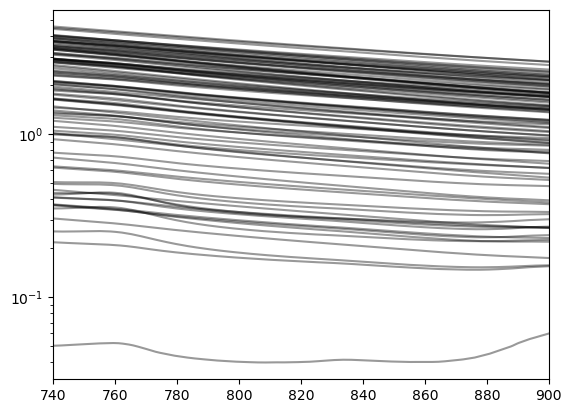

individual absorption


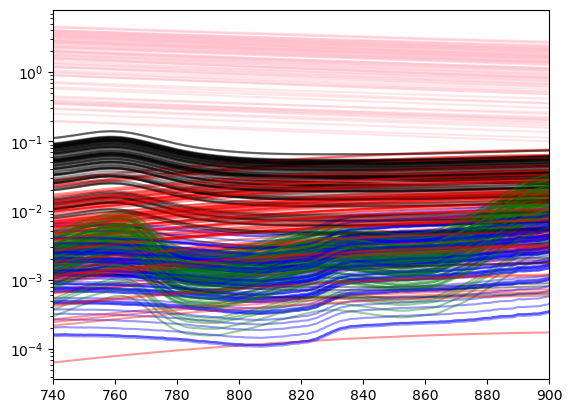

scattering


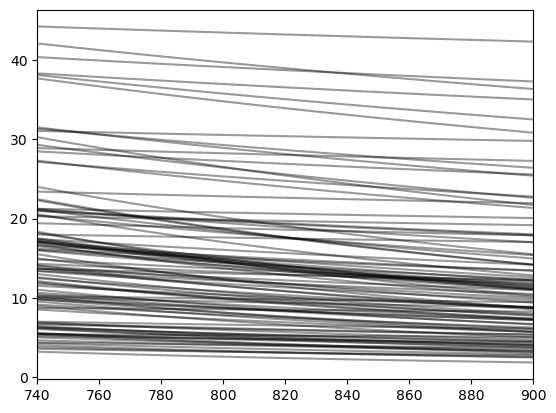

In [5]:
wl_range = (740, 900)
prior_abs = prior['prior'].absorption[0, ...]

print('total absorption')
plt.figure()
for row in prior_abs:
    plt.plot(wls, row, color='black', alpha=0.4)

plt.yscale('log')
plt.xlim(wl_range)
plt.show()

print('individual absorption')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].water_abs[0, i, :], color='blue', alpha=0.4)
    plt.plot(wls, prior['prior'].oxy_abs[0, i, :], color='red', alpha=0.4)
    plt.plot(wls, prior['prior'].deoxy_abs[0, i, :], color='black', alpha=0.4)
    plt.plot(wls, prior['prior'].lipid_abs[0, i, :], color='green', alpha=0.4)
    plt.plot(wls, prior['prior'].mel_abs[0, i, :], color='pink', alpha=0.4)
plt.xlim(wl_range)
plt.yscale('log')
plt.show()

print('scattering')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].scattering[0, i, :], color='black', alpha=0.4)
plt.xlim(wl_range)
plt.show()

individual absorption


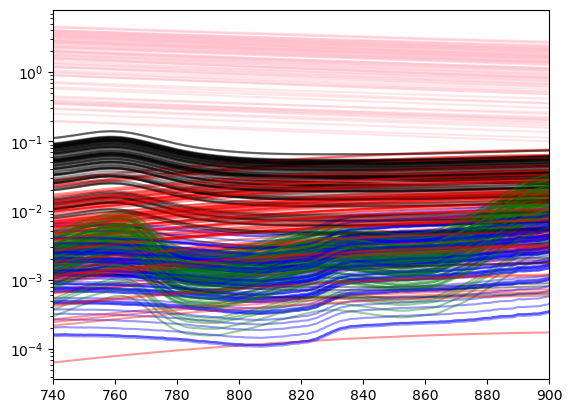

In [6]:
print('individual absorption')
plt.figure()
for i in prior['prior'].draw:
    plt.plot(wls, prior['prior'].water_abs[0, i, :], color='blue', alpha=0.4)
    plt.plot(wls, prior['prior'].oxy_abs[0, i, :], color='red', alpha=0.4)
    plt.plot(wls, prior['prior'].deoxy_abs[0, i, :], color='black', alpha=0.4)
    plt.plot(wls, prior['prior'].lipid_abs[0, i, :], color='green', alpha=0.4)
    plt.plot(wls, prior['prior'].mel_abs[0, i, :], color='pink', alpha=0.4)
plt.xlim(wl_range)
plt.yscale('log')
plt.show()

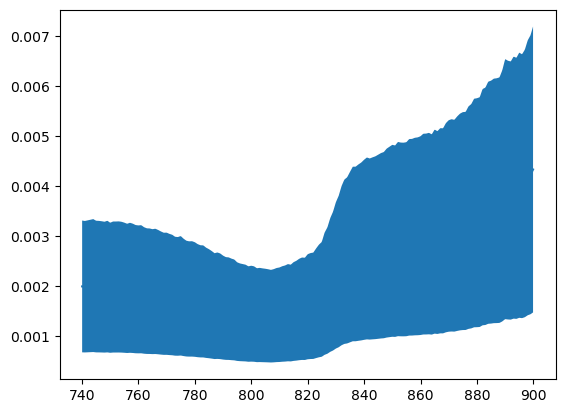

In [21]:
from constants.colors import colors 

wl_mask = (740 < wls) & (wls < 900)
limited_wls = wls[wl_mask]

props = ['water_abs', 'lipid_abs', 'deoxy_abs', 'oxy_abs', 'mel_abs']
prop_colors = ['blue', 'grape', 'black', 'blue', 'orange']

for prop, color in zip(props, prop_colors) 

water_abs = np.array(prior['prior'].water_abs[0, :, wl_mask])

water_mean = np.mean(water_abs, axis=0)
water_std = np.std(water_abs, axis=0)

plt.figure()
plt.fill_between(limited_wls, water_mean - water_std, water_mean + water_std)
plt.plot(limited_wls, water_mean)
plt.show()

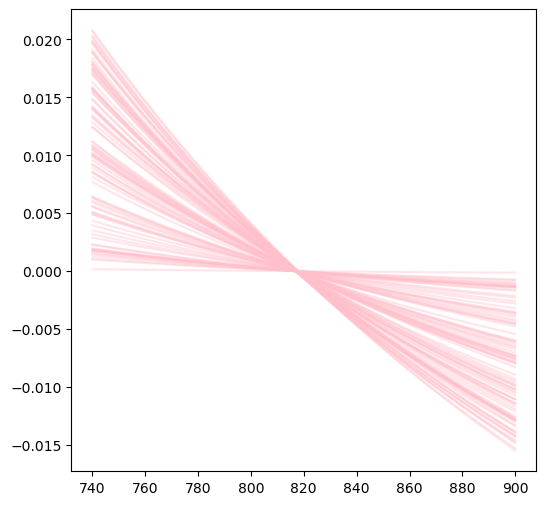

In [7]:
# error in ignoring melanin

plt.figure(figsize=(6,6))

L = 0.02

for i in prior['prior'].draw:
    mel_abs = prior['prior'].mel_abs[0, i, :]
    diff = mel_abs - np.mean(mel_abs)
    error = diff*L
    plt.plot(wls, error, color='pink', alpha=0.4)

plt.show()